In [16]:
import sys
# sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# Data
from dataclasses import dataclass
from src.data.regression import load_esdc

# Feature Extraction/Transformations
from esdc.transform import DensityCubes
from src.features.stats import calculate_regression_stats
from src.features.regression import get_density_cubes

# GP Models
from src.models.regression import gpr_naive, predict_batches
from src.models.derivatives import GPRDerivative
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Visualization
from esdc.visualize import plot_xarray_on_map, plot_map
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
xr.set_options(display_style='html')
plt.style.use(['seaborn-talk'])

# notebook extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment

In [17]:
@dataclass
class Parameters:
    exp_name = "test"
    spatial = 3
    seed = 123
    variable = "gross_primary_productivity"
    train_size = 5_000
    restarts = 10
    normalize_y = True

## Data

For this experiment, we are going to be looking at the region of Europe for the duration of the year 2010. The variables in question are Gross Primary Productivity (GPP) and Land Surface Temperature (LST)

In [18]:
cube_europe = load_esdc('gross_primary_productivity')
cube_europe

<xarray.DataArray 'gross_primary_productivity' (time: 46, lat: 144, lon: 312)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.4173916 ,
         0.6403752 , 0.67987144],
        [       nan,        nan,        nan, ..., 0.413061  ,
         0.44576514, 0.56976384],
        [       nan,        nan,        nan, ..., 0.3491871 ,
         0.29376552, 0.43930927]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.28760272,
         0.3845786 , 0.3757068 ],
        [       nan,        nan,        nan, ..., 0.26979852,
         0.3229287 , 0.38997903],
        [       nan,        nan,        nan, ..., 0.2551113 ,
         0.2532658 , 0.33186838]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.60803545,
         0.63989407, 0.56857246],
        [       nan,        nan,        nan, ..., 0.49904317,
         0.53187007, 0.51037824],
        [       nan,        nan,        nan, ..., 0.45544842,
         0.37197873, 0.4620728 ]],

       ...,

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.37868193,
         0.42721385, 0.47857657],
        [       nan,        nan,        nan, ..., 0.4326775 ,
         0.48118907, 0.46354705],
        [       nan,        nan,        nan, ..., 0.40883398,
         0.3604496 , 0.4272509 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.29093036,
         0.32771698, 0.3568814 ],
        [       nan,        nan,        nan, ..., 0.3188329 ,
         0.30967742, 0.32755807],
        [       nan,        nan,        nan, ..., 0.37522689,
         0.29264805, 0.33941773]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.30328733,
         0.32736248, 0.36932132],
        [       nan,        nan,        nan, ..., 0.31946707,
         0.36217266, 0.341024  ],
        [       nan,        nan,        nan, ..., 0.3333804 ,
         0.300925  , 0.34496197]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * time     (time) datetime64[ns] 2010-01-05 2010-01-13 ... 2010-12-31
Attributes:
    ID:                        47
    esa_cci_path:              nan
    long_name:           

### Visualize

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


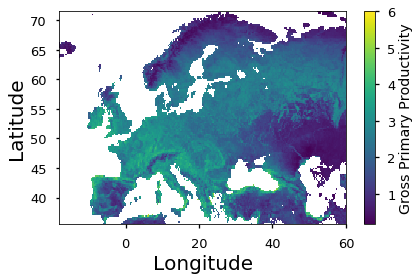

In [19]:
fig, ax = plot_map(
    cube_europe.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

## Extract MiniCubes

In [20]:
DensityCubes?

Init signature:
DensityCubes(
    spatial_window=3,
    time_window=3,
    spatial_step=1,
    time_step=1,
    temporal_point='end',
)
Docstring:     
A class that extracts subsets of cubes from the xarray datacube. This cube is designed
to work with xr.DataArray structures with 2 spatial dimensions and 1 temporal (e.g. 
lat-lon-time). This is useful for density estimation and feature inclusion when we want to have 
more features/dimensions that stem from the spatial and temporal dimensions. Uses 
numpy strides to reduce the amount of memory overhead and is relatively quick.

Parameters
----------
spatial_window : int, default=3
    The number of dimensions for the spatial windows (x2) for the cube.
    Note: if the time window is even then we take the ceil 

time_window : int, default = 3
    The number of dimensions for the temporal window (x1) for the cube.

spatial_step : int, default = 1
    The amount of steps in the spatial direction for the spatial windows.

time_step : int, d

#### Save MiniCubes

In [21]:
spatial_window = 3
time_window = 1
# save_name = 'sakame'
minicuber = DensityCubes(spatial_window=spatial_window, time_window=time_window)

# get density Cubes
minicube_gpp_df = minicuber.get_minicubes(cube_europe)

### Get Common Elements 

We need to reduce the dataframes such that they have the same elements. 

In [22]:
minicube_gpp_df, minicube_lst_df = get_common_elements(
    minicube_gpp_df, minicube_lst_df
)

NameError: name 'get_common_elements' is not defined

In [23]:
minicube_gpp_df.shape, minicube_lst_df.shape

NameError: name 'minicube_lst_df' is not defined

In [24]:
gpp_df = get_density_cubes(cube_europe, 3)

## Train-Test Split

Since we are doing the most naive thing, we don't need to do too much preprocessing. We simply need to split the data into training and testing. I will be using 3_000 datapoints for training.

In [25]:
gpp_df.head()

var_x0    var_x1    var_x2    var_x3    var_x4  \
time       lat    lon                                                        
2010-01-05 71.125 53.875  0.053806  0.044599  0.048788  0.053304  0.047147   
                  54.125  0.044599  0.048788  0.055258  0.047147  0.039044   
                  54.375  0.048788  0.055258  0.058324  0.039044  0.048202   
                  54.625  0.055258  0.058324  0.052806  0.048202  0.050750   
                  54.875  0.058324  0.052806  0.040361  0.050750  0.050774   

                            var_x5    var_x6    var_x7    var_x8  
time       lat    lon                                             
2010-01-05 71.125 53.875  0.039044  0.048175  0.038201  0.032684  
                  54.125  0.048202  0.038201  0.032684  0.046753  
                  54.375  0.050750  0.032684  0.046753  0.057535  
                  54.625  0.050774  0.046753  0.057535  0.049402  
                  54.875  0.061176  0.057535  0.049402  0.054017

In [27]:
# training test
X = gpp_df.iloc[:, 1:]
y = gpp_df.iloc[:, 0]


Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=3_000, random_state=123
)

In [28]:
X.head()

var_x1    var_x2    var_x3    var_x4    var_x5  \
time       lat    lon                                                        
2010-01-05 71.125 53.875  0.044599  0.048788  0.053304  0.047147  0.039044   
                  54.125  0.048788  0.055258  0.047147  0.039044  0.048202   
                  54.375  0.055258  0.058324  0.039044  0.048202  0.050750   
                  54.625  0.058324  0.052806  0.048202  0.050750  0.050774   
                  54.875  0.052806  0.040361  0.050750  0.050774  0.061176   

                            var_x6    var_x7    var_x8  
time       lat    lon                                   
2010-01-05 71.125 53.875  0.048175  0.038201  0.032684  
                  54.125  0.038201  0.032684  0.046753  
                  54.375  0.032684  0.046753  0.057535  
                  54.625  0.046753  0.057535  0.049402  
                  54.875  0.057535  0.049402  0.054017

## Train GPR Model

In [9]:
gpr_model = gpr_naive(
    Xtrain.values, 
    ytrain.values[:, None], 
    n_restarts_optimizer=0, 
    normalize_y=True, 
    random_state=123
)

## Predictions w. GP Model

We will have to predict in batches because it is a lot of data

In [10]:
# initialize GPR Derivative Model
gpr_der_model = GPRDerivative(gpr_model)

# make predictions of batches
predictions, derivatives = predict_batches(
    gpr_model, 
    gpr_der_model, 
    Xtest.values, 
    ytest.values, 
    batch_size=10_000
)

### Calculate Statistics

Below is a helper function that takes in the labels, predictions and derivatives and returns an `xarray.Dataset` with the results that include the lat, lon and time components. This makes plotting a lot easier.

In [11]:
xr_results = calculate_stats(
    ypred=predictions, 
    ytest=ytest.values[:, None], 
    derivative=derivatives, 
    index=ytest.index
)
xr_results

<xarray.Dataset>
Dimensions:      (lat: 142, lon: 294, time: 46)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-05 2010-01-13 ... 2010-12-31
  * lat          (lat) float64 35.88 36.12 36.38 36.62 ... 70.62 70.88 71.12
  * lon          (lon) float64 30.88 31.12 21.38 18.12 ... -17.62 -14.62 -14.12
Data variables:
    Predictions  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Labels       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    Error        (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Sensitivity  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    r2:       0.8947068735770295

In [ ]:
xr_results.coords['']

## Plots

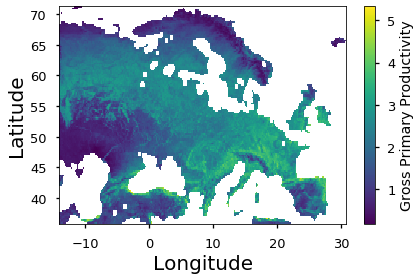

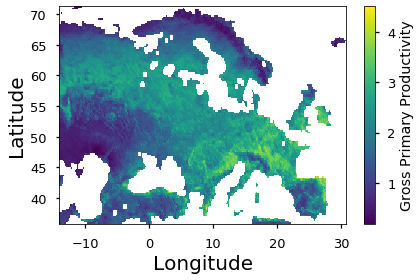

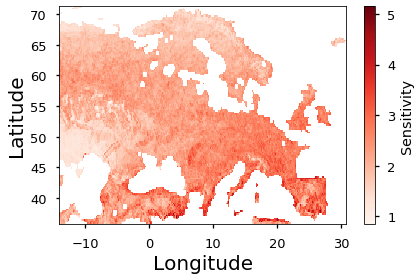

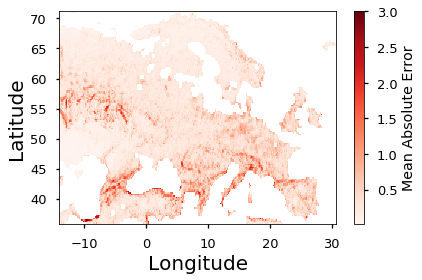

In [13]:
fig, ax = plot_map(
    xr_results.Labels.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Predictions.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Sensitivity.mean(dim='time'),
    cmap="Reds",
    cbar_kwargs = {'label':'Sensitivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_results.Error.mean(dim='time'),
    cmap="Reds",
#     robust=True,
    cbar_kwargs = {'label':'Mean Absolute Error'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()